In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

# from matplotlib import style
# style.use('fivethirtyeight')
sns.set_style("whitegrid")

In [2]:
data_dir = "../input/gtsrb-german-traffic-sign"
train_path = "../input/gtsrb-german-traffic-sign/Train"
test_path = "../input/gtsrb-german-traffic-sign/Test"

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir("../input/gtsrb-german-traffic-sign/Train"))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

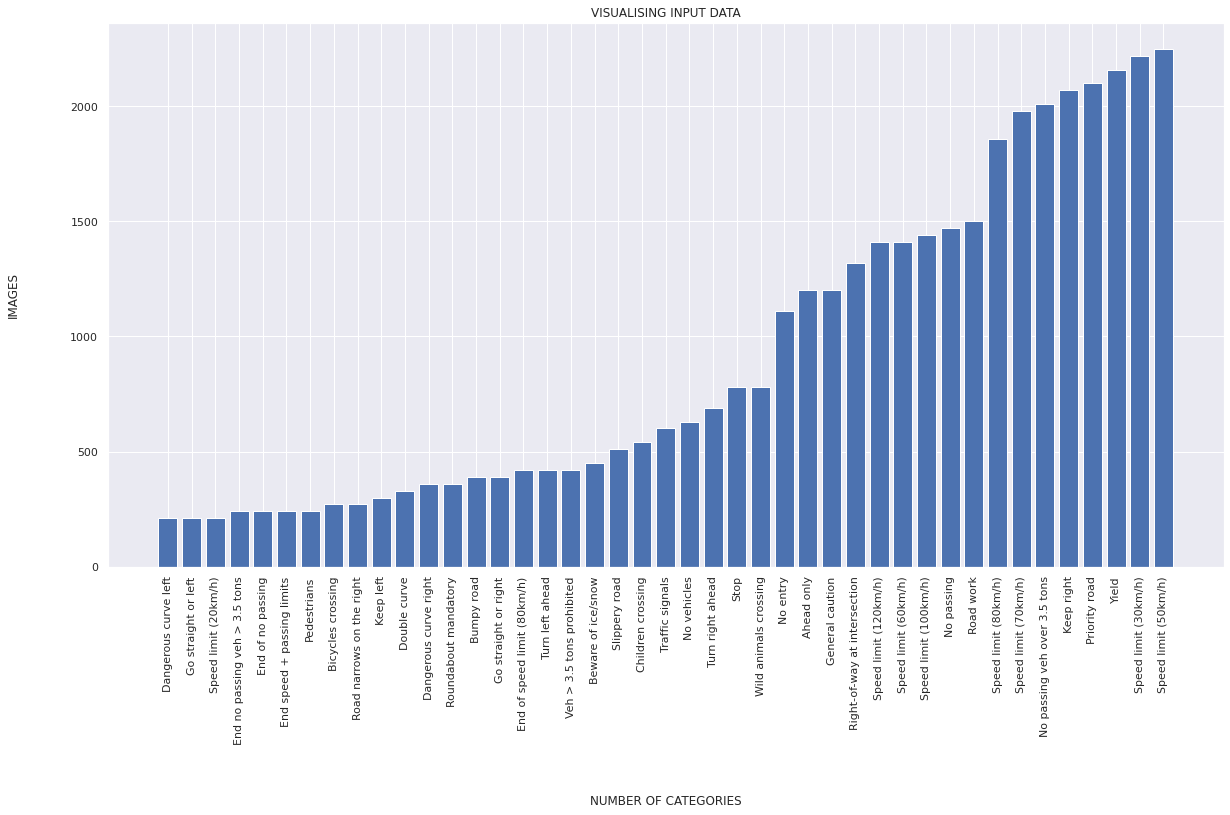

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

sns.set_theme(style="darkgrid")

# Plotting the number of images in each class
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 60}

# plt.rc('font', **font)

# sns.set_theme(style="white", context="talk")


plt.figure(figsize=(20,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.xlabel("NUMBER OF CATEGORIES",labelpad=50)
plt.ylabel("IMAGES",labelpad=50)
plt.title("VISUALISING INPUT DATA")

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app


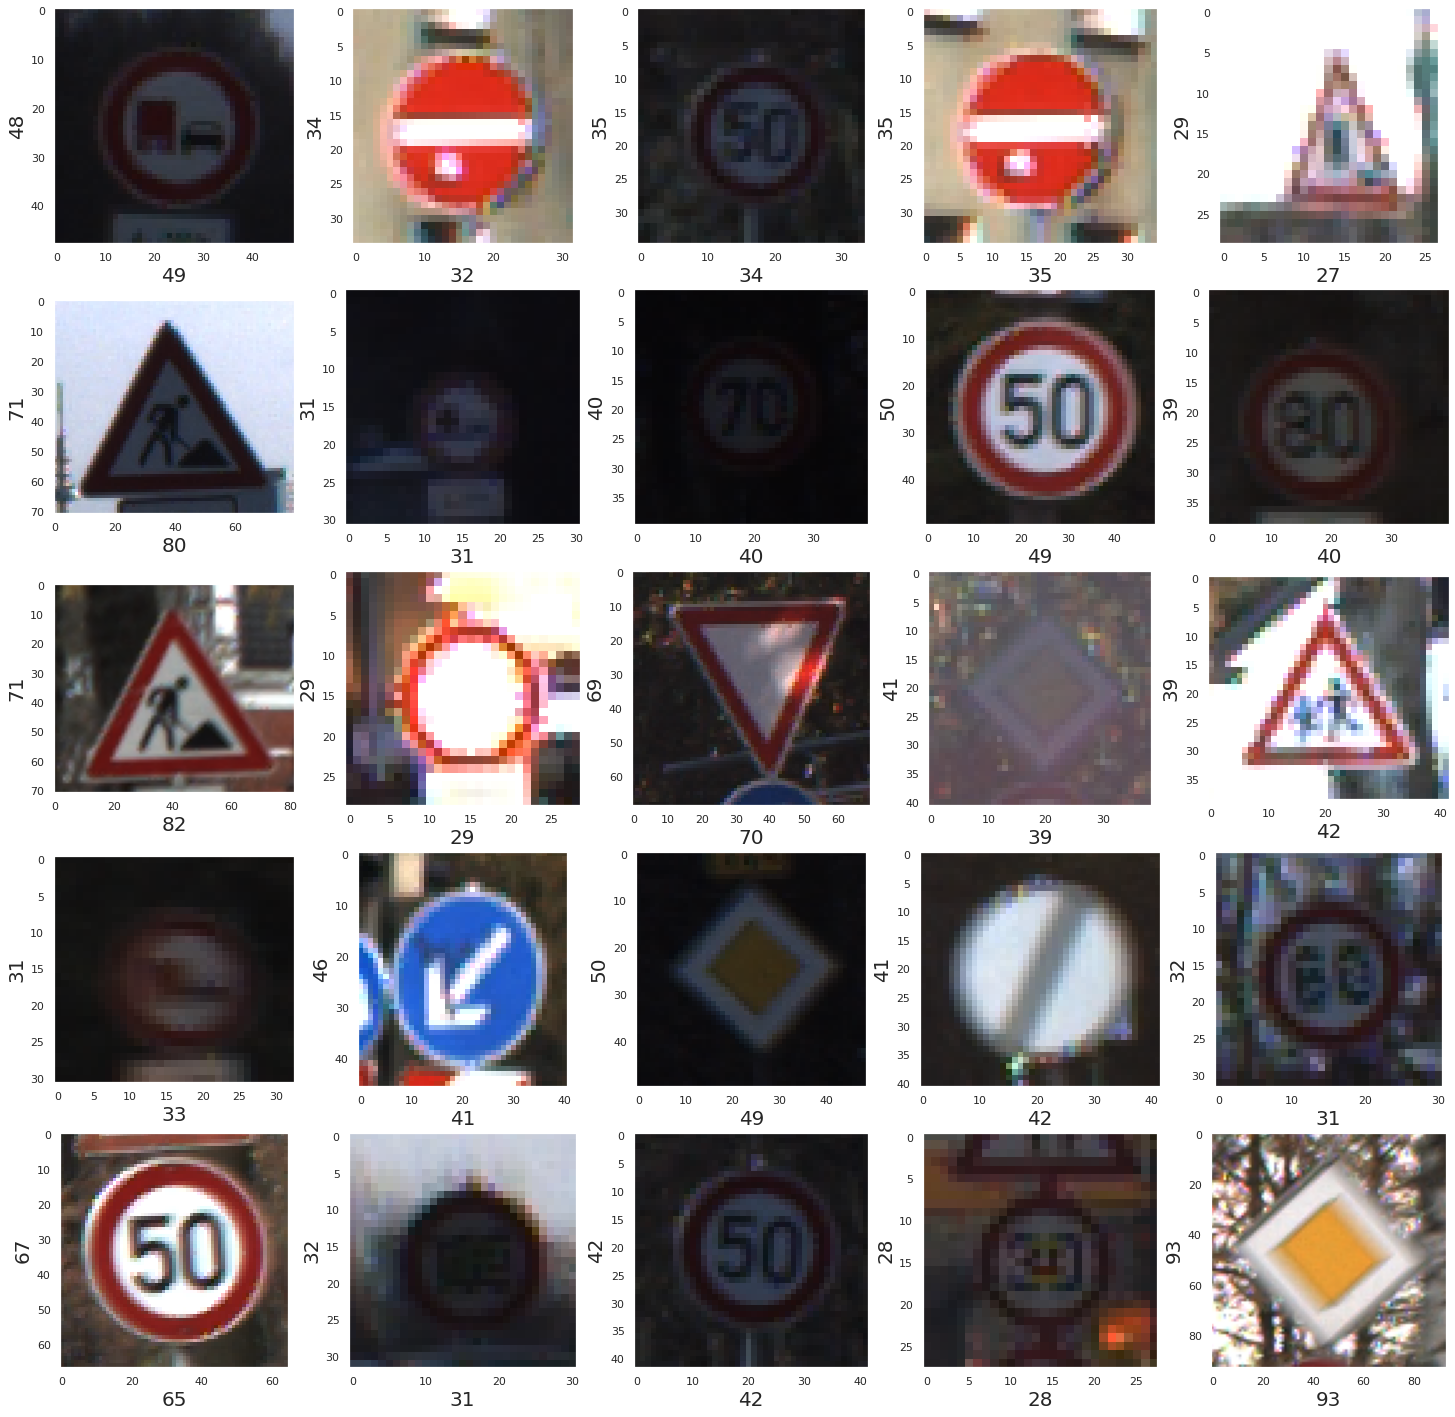

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [10]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [11]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

2022-07-11 09:59:21.504429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 09:59:21.644424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 09:59:21.645373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 09:59:21.646817: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

2022-07-11 09:59:24.744995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-07-11 09:59:26.370658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


858/858 [==============================] - 24s 19ms/step - loss: 1.0263 - accuracy: 0.7231 - val_loss: 0.1127 - val_accuracy: 0.9637
Epoch 2/30
858/858 [==============================] - 15s 18ms/step - loss: 0.1755 - accuracy: 0.9464 - val_loss: 0.0790 - val_accuracy: 0.9783
Epoch 3/30
858/858 [==============================] - 16s 19ms/step - loss: 0.1076 - accuracy: 0.9669 - val_loss: 0.0392 - val_accuracy: 0.9877
Epoch 4/30
858/858 [==============================] - 16s 19ms/step - loss: 0.0838 - accuracy: 0.9749 - val_loss: 0.0148 - val_accuracy: 0.9955
Epoch 5/30
858/858 [==============================] - 16s 19ms/step - loss: 0.0646 - accuracy: 0.9800 - val_loss: 0.0204 - val_accuracy: 0.9940
Epoch 6/30
858/858 [==============================] - 16s 18ms/step - loss: 0.0550 - accuracy: 0.9824 - val_loss: 0.0140 - val_accuracy: 0.9968
Epoch 7/30
858/858 [==============================] - 16s 19ms/step - loss: 0.0517 - accuracy: 0.9844 - val_loss: 0.0192 - val_accuracy: 0.9947
Epo

In [14]:
# model.save_weights("/content/drive/MyDrive/GTSRB_OUTPUT")

# serialize model to JSON
model_json = model.to_json()
with open("CNN_CUSTOM_MODEL.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_CUSTOM_MODEL.h5")
print("Saved model to disk")

Saved model to disk


In [15]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'principal_components',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standa

In [16]:
from keras.models import model_from_json

# load json and create model
json_file = open('CNN_CUSTOM_MODEL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("CNN_CUSTOM_MODEL.h5")
model.save("CUSTOM_MODEL")

2022-07-11 10:07:49.752129: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


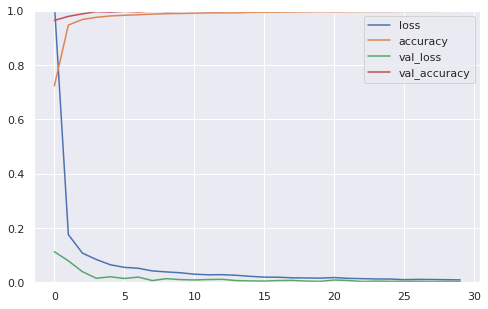

In [17]:
sns.set_theme(style="darkgrid")
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [18]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test), axis=-1)
# y_predict = np.argmax(model.predict(x_test), axis=-1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.56690419635787


In [19]:
from sklearn.metrics import confusion_matrix
import cv2
cf = confusion_matrix(labels, pred)

<AxesSubplot:>

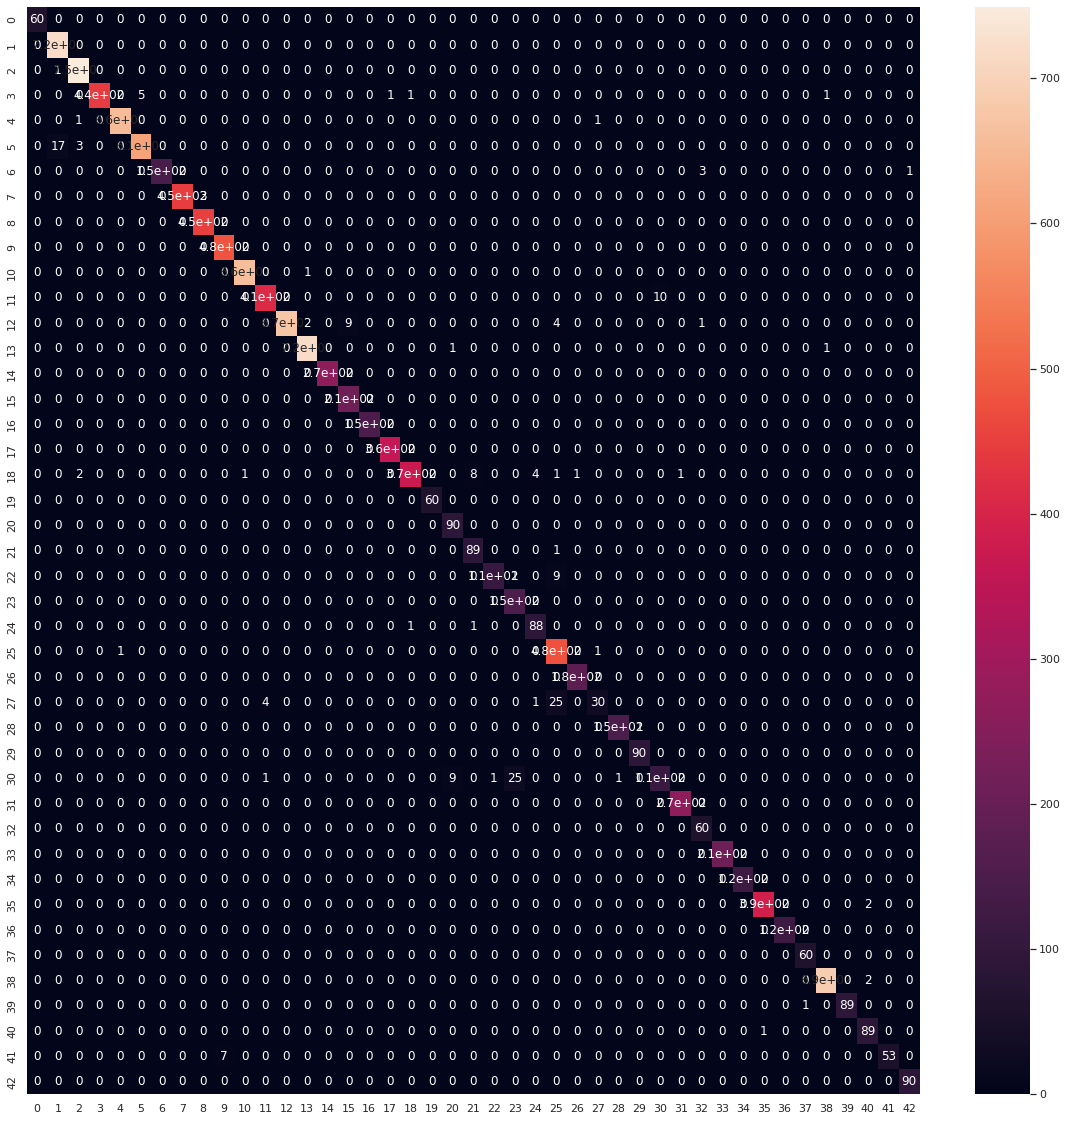

In [20]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      1.00      0.99       720
           2       0.99      1.00      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      0.97      0.98       630
           6       1.00      0.97      0.99       150
           7       1.00      0.99      1.00       450
           8       0.99      1.00      1.00       450
           9       0.99      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.99      0.98      0.98       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.96      1.00      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

# **TESTING IMAGES**

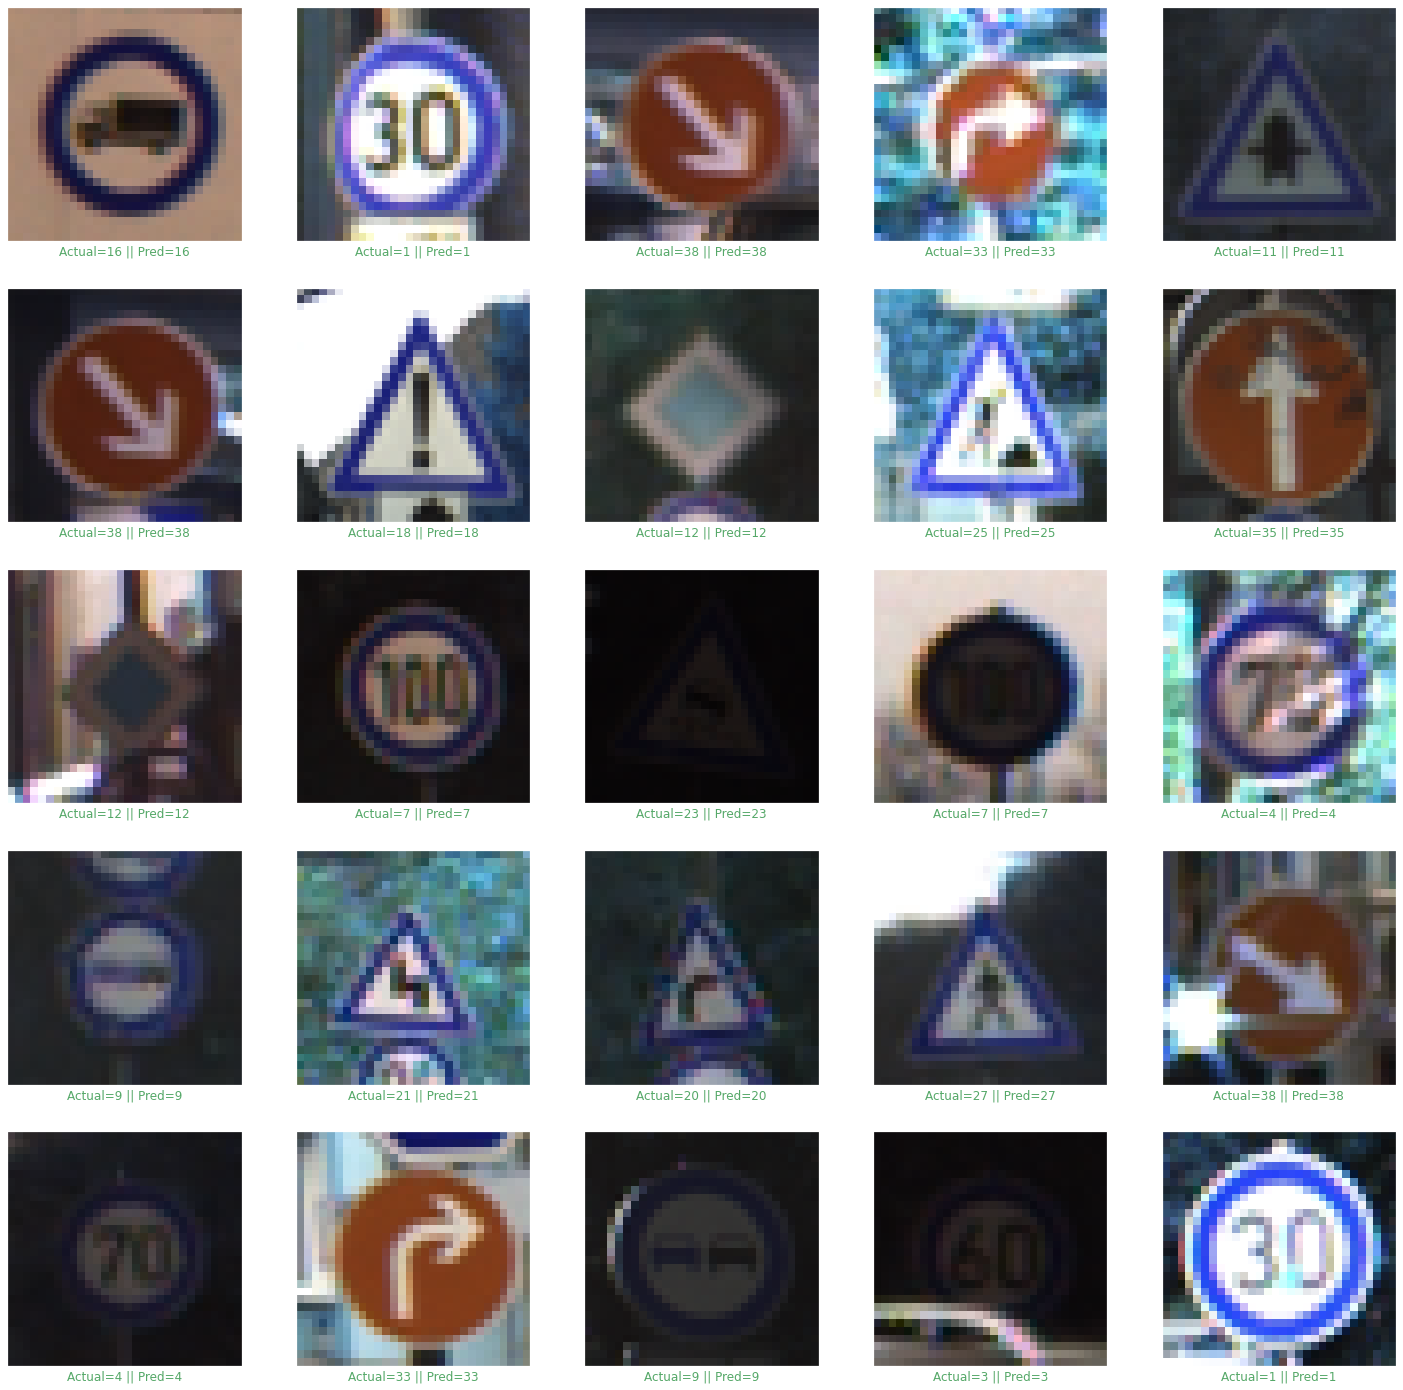

In [22]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()